In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
# Agregar la carpeta 'src' al sistema de rutas
sys.path.append(os.path.abspath('../src'))
# Ahora puedes importar el archivo o los módulos
#from pricing_tools import *

import scipy.stats as stats
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import statsmodels.api as sm

In [2]:
def graficar_barras_linea(df, x_col, y_col_barras, y_col_linea, titulo="Gráfico combinado de barras y línea"):
    """
    Función para graficar un diagrama de barras con una línea superpuesta.

    Parámetros:
    - df: DataFrame de Pandas.
    - x_col: Nombre de la columna para el eje x (categorías).
    - y_col_barras: Nombre de la columna para el eje y de las barras (pesos).
    - y_col_linea: Nombre de la columna para el eje y de la línea (variable de respuesta).
    - titulo: Título del gráfico (opcional).
    """

    # Crear el gráfico
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Graficar las barras
    ax1.bar(df[x_col], df[y_col_barras], color='skyblue', label=y_col_barras, alpha=0.7)

    # Etiquetas para el eje de las barras
    ax1.set_xlabel(x_col)
    ax1.set_ylabel(y_col_barras, color='skyblue')
    ax1.tick_params(axis='y', labelcolor='skyblue')

    # Crear un segundo eje Y para la línea
    ax2 = ax1.twinx()  # Comparte el mismo eje X

    # Graficar la línea
    ax2.plot(df[x_col], df[y_col_linea], color='orange', marker='o', label=y_col_linea)

    # Etiquetas para el eje de la línea
    ax2.set_ylabel(y_col_linea, color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

    # Título
    plt.title(titulo)

    # Rotar etiquetas del eje X si es necesario
    plt.xticks(rotation=90)

    # Asegurar que no se solapen los gráficos
    plt.tight_layout()

    # Mostrar el gráfico
    plt.show()

def generar_formato_exposicion_homogenea(df, columna_interes, columna_exposicion, num_beans):
    """
    Genera un formato de beans con exposición homogénea basados en la exposición de otra columna y devuelve la columna
    de interés con el formato aplicado.

    :param df: DataFrame que contiene los datos.
    :param columna_interes: Nombre de la columna de interés que se quiere agrupar en bins.
    :param columna_exposicion: Nombre de la columna que contiene la exposición o peso.
    :param distribucion: Tipo de distribución ('normal', 'uniforme', etc.) para ajustar los beans (parámetro no usado en esta versión).
    :param num_beans: Número de beans o grupos a crear.
    :return: Serie con la columna de interés formateada en beans de exposición constante.
    """

    # Ordenar el DataFrame por la columna de interés para crear beans adecuados
    df = df.sort_values(by=columna_interes).reset_index(drop=True)

    # Calcular la exposición total y la exposición por cada bean
    exposicion_total = df[columna_exposicion].sum()
    exposicion_por_bean = exposicion_total / num_beans

    # Variable para rastrear la exposición acumulada y asignar beans
    exposicion_acumulada = 0
    limites_beans = []
    current_bean = 1
    limite_actual = df[columna_interes].iloc[0]  # Inicia en el valor mínimo

    # Recorrer el DataFrame fila por fila para crear los bins basados en exposición
    for i, fila in df.iterrows():
        exposicion_acumulada += fila[columna_exposicion]

        # Si alcanzamos la exposición deseada para este bin, guardar el límite superior
        if exposicion_acumulada >= exposicion_por_bean:
            limite_actual = fila[columna_interes]
            limites_beans.append(limite_actual)
            exposicion_acumulada = 0
            current_bean += 1
            if current_bean > num_beans:
                break  # No más beans después del número establecido

    # Si el número de beans es menor al solicitado, añadimos el máximo valor como último límite
    if len(limites_beans) < num_beans:
        limites_beans.append(df[columna_interes].max())

    # Usar pd.cut para aplicar los límites de los beans
    df['Columna_formateada'] = pd.cut(df[columna_interes], bins=[-np.inf] + limites_beans, duplicates='drop')

    return df['Columna_formateada']

### Leemos el diccionario de variables

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Leemos el dataframe

In [4]:
dict = pd.read_excel("/content/drive/MyDrive/data_dict.xlsx")
dict.head()

,Factores,NUMERICA,ORDINAL,CONTINUA,DISCRETA,LABEL,CATEGORÍA,MISSING,format
0,AGRUPAGENTE,1,0.0,0,1.0,Agrupacion del agente,03.Agente,True,FMT_AGRUPAGENTE
1,Altitud,1,1.0,0,1.0,Altitud (m),06.Geográfica,True,FMT_Altitud
2,antigedif,1,1.0,0,1.0,Antiguedad del edificio,04.Riesgo,True,FMT_antigedif
3,antigref,1,1.0,0,1.0,Antiguedad de la reforma,04.Riesgo,True,FMT_antigref
4,ANTIGUEDAD_VIVIENDA,1,1.0,0,1.0,Antiguedad de la vivienda (new),04.Riesgo,True,FMT_ANTIGUEDAD_VIVIENDA


In [5]:
df_muestra=pd.read_parquet("/content/drive/MyDrive/AGUA_V2_40.parquet")
#df_.head()

In [6]:
#Por si llegase a ser necesario reducir el tamaño del df para el analisis
df_muestra = df_muestra.sample(n=len(df_muestra))

In [7]:
###Definimos las variables de respuesta y peso
var_resp='stro_Corr_AGUAACAGBC'
peso='exp_corr_ACAGBC'
ano='year'

In [8]:
df_muestra=df_muestra[df_muestra[peso]>0]

In [9]:
df_muestra['resp']=df_muestra[var_resp]/df_muestra[peso]

In [10]:
def graficar_histograma(df, columna, bins=10, titulo="Histograma", xlabel="Valores", ylabel="Frecuencia"):
    """
    Grafica un histograma de una variable específica de un DataFrame.

    Parámetros:
    - df: DataFrame de pandas que contiene los datos.
    - columna: Nombre de la columna que se desea graficar (str).
    - bins: Número de bins en el histograma (opcional, por defecto 10).
    - titulo: Título del gráfico (opcional).
    - xlabel: Etiqueta para el eje X (opcional).
    - ylabel: Etiqueta para el eje Y (opcional).
    """
    # Comprobamos si la columna existe en el DataFrame
    if columna not in df.columns:
        print(f"La columna '{columna}' no se encuentra en el DataFrame.")
        return

    # Graficar el histograma
    plt.figure(figsize=(8, 6))
    plt.hist(df[columna].dropna(), bins=bins, color="skyblue", edgecolor="black")
    plt.title(titulo)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

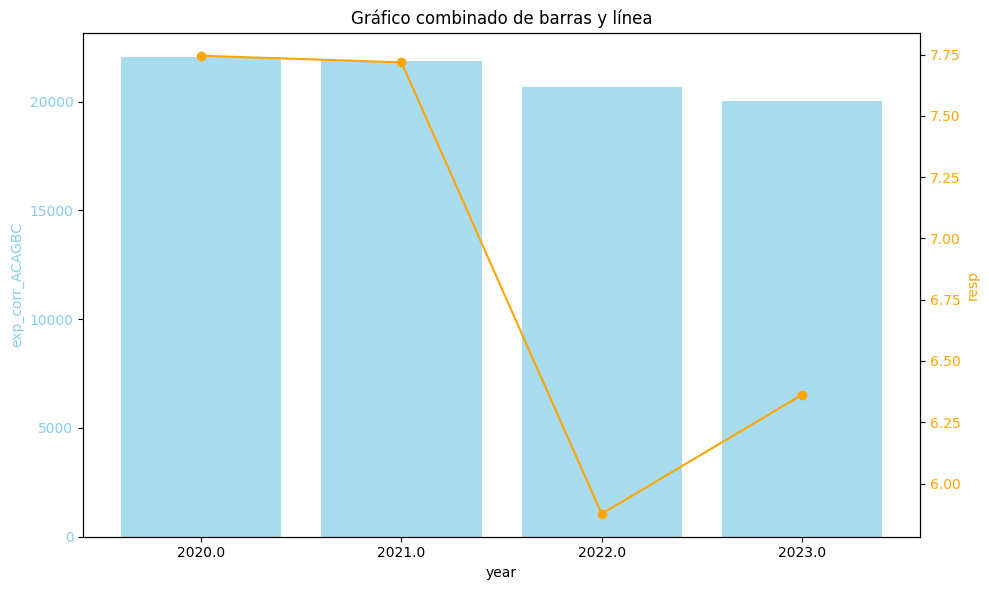

In [11]:
#Estudiamos la composicion de la cartera por años
df_muestra[ano]=df_muestra[ano].astype(str)
df_resumido = df_muestra.groupby(ano).agg({peso: 'sum', 'resp': 'mean'}).reset_index()
graficar_barras_linea(df_resumido,ano,peso,'resp')

In [5]:
# Lista de las 30 variables seleccionadas
variables_seleccionadas = [
    "Altitud", "antigedif", "antigref", "ANTIGUEDAD_VIVIENDA", "anualidad_reemplazo",
    "anualidad_seguro", "AnyoCons_edif", "AnyoCons_edif_total", "AUX", "bloqueo",
    "cl_cobro", "codigo_grp", "CODINE", "CODPOST", "CODPROV", "Contr_Agr_pct",
    "Contr_Cons_pct", "Contr_ConvIndefH_pct", "Contr_ConvIndefm_pct", "Contr_Ind_pct",
    "Contr_IndefH_pct", "Contr_IndefM_pct", "Contr_Serv_pct", "Contr_TempH_pct",
    "Contr_Tempm_pct", "Contr_tot_pct", "Conv_AVG", "CORINE_VARIETY",
    "CUPD_CAP_Corr_aguaacagbc", "CUPD_Exc_aguaacagbc"
]

vector_variables = pd.Series(variables_seleccionadas, name="Variables Seleccionadas")

# Mostrar el vector
print(vector_variables)

0                      Altitud
1                    antigedif
2                     antigref
3          ANTIGUEDAD_VIVIENDA
4          anualidad_reemplazo
5             anualidad_seguro
6                AnyoCons_edif
7          AnyoCons_edif_total
8                          AUX
9                      bloqueo
10                    cl_cobro
11                  codigo_grp
12                      CODINE
13                     CODPOST
14                     CODPROV
15               Contr_Agr_pct
16              Contr_Cons_pct
17        Contr_ConvIndefH_pct
18        Contr_ConvIndefm_pct
19               Contr_Ind_pct
20            Contr_IndefH_pct
21            Contr_IndefM_pct
22              Contr_Serv_pct
23             Contr_TempH_pct
24             Contr_Tempm_pct
25               Contr_tot_pct
26                    Conv_AVG
27              CORINE_VARIETY
28    CUPD_CAP_Corr_aguaacagbc
29         CUPD_Exc_aguaacagbc
Name: Variables Seleccionadas, dtype: object


In [6]:
# Importar las bibliotecas necesarias
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Cargar el archivo parquet
df_muestra = pd.read_parquet("/content/drive/MyDrive/AGUA_V2_40.parquet")

# Definir las variables de respuesta y peso
var_resp = 'stro_Corr_AGUAACAGBC'
peso = 'exp_corr_ACAGBC'
ano = 'year'

# Crear la variable de respuesta 'resp' en el DataFrame
df_muestra = df_muestra[df_muestra[peso] > 0]  # Filtrar filas con peso positivo
df_muestra['resp'] = df_muestra[var_resp] / df_muestra[peso]  # Definir la variable de respuesta

# Definir las variables seleccionadas
variables_seleccionadas = [
    "Altitud", "antigedif", "antigref", "ANTIGUEDAD_VIVIENDA", "anualidad_reemplazo",
    "anualidad_seguro", "AnyoCons_edif", "AnyoCons_edif_total", "AUX", "bloqueo",
    "cl_cobro", "codigo_grp", "CODINE", "CODPOST", "CODPROV", "Contr_Agr_pct",
    "Contr_Cons_pct", "Contr_ConvIndefH_pct", "Contr_ConvIndefm_pct", "Contr_Ind_pct",
    "Contr_IndefH_pct", "Contr_IndefM_pct", "Contr_Serv_pct", "Contr_TempH_pct",
    "Contr_Tempm_pct", "Contr_tot_pct", "Conv_AVG", "CORINE_VARIETY",
    "CUPD_CAP_Corr_aguaacagbc", "CUPD_Exc_aguaacagbc"
]

# Verificar que las variables seleccionadas estén presentes en el DataFrame
variables_presentes = [var for var in variables_seleccionadas if var in df_muestra.columns]
faltantes = [var for var in variables_seleccionadas if var not in df_muestra.columns]

if faltantes:
    print(f"Las siguientes columnas faltan en el DataFrame y deben añadirse: {faltantes}")
else:
    print("Todas las columnas necesarias están presentes.")

# Manejar valores nulos
df_muestra = df_muestra[variables_presentes + ['resp']].copy()  # Filtrar columnas necesarias
df_muestra.fillna(df_muestra.median(numeric_only=True), inplace=True)  # Reemplazar valores nulos numéricos con la mediana

# Identificar variables categóricas
categorical_vars = df_muestra.select_dtypes(include=['object', 'category']).columns.tolist()

# Limitar categorías de variables categóricas a un máximo de 10
for var in categorical_vars:
    top_categories = df_muestra[var].value_counts().index[:10]
    df_muestra[var] = df_muestra[var].apply(lambda x: x if x in top_categories else "Otros")

# Convertir variables categóricas a dummies
df_encoded = pd.get_dummies(df_muestra, columns=categorical_vars, drop_first=True)

# Optimizar tipos de datos para reducir el uso de memoria
for col in df_encoded.select_dtypes(include=['float64']).columns:
    df_encoded[col] = df_encoded[col].astype('float32')

for col in df_encoded.select_dtypes(include=['int64']).columns:
    df_encoded[col] = df_encoded[col].astype('int16')

# Definir las variables predictoras (X) y la variable de respuesta (y)
X = df_encoded.drop(columns=['resp'])  # Variables predictoras
y = df_encoded['resp']  # Variable de respuesta

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Crear el modelo Random Forest
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)

# Entrenar el modelo
random_forest.fit(X_train, y_train)

# Extraer las importancias de las características
importancias = pd.DataFrame({
    "Variable": X_train.columns,
    "Importancia": random_forest.feature_importances_
}).sort_values(by="Importancia", ascending=False)

# Seleccionar las 8 variables más importantes
top_8_variables = importancias.head(8)

# Mostrar las variables más importantes
print("\nLas 8 variables más importantes según el Random Forest son:")
print(top_8_variables)



Todas las columnas necesarias están presentes.

Las 8 variables más importantes según el Random Forest son:
                    Variable  Importancia
24  CUPD_CAP_Corr_aguaacagbc     0.303893
1                  antigedif     0.066961
3        ANTIGUEDAD_VIVIENDA     0.065086
8                        AUX     0.054565
5           anualidad_seguro     0.054513
22                  Conv_AVG     0.041602
6              AnyoCons_edif     0.030132
7        AnyoCons_edif_total     0.026169


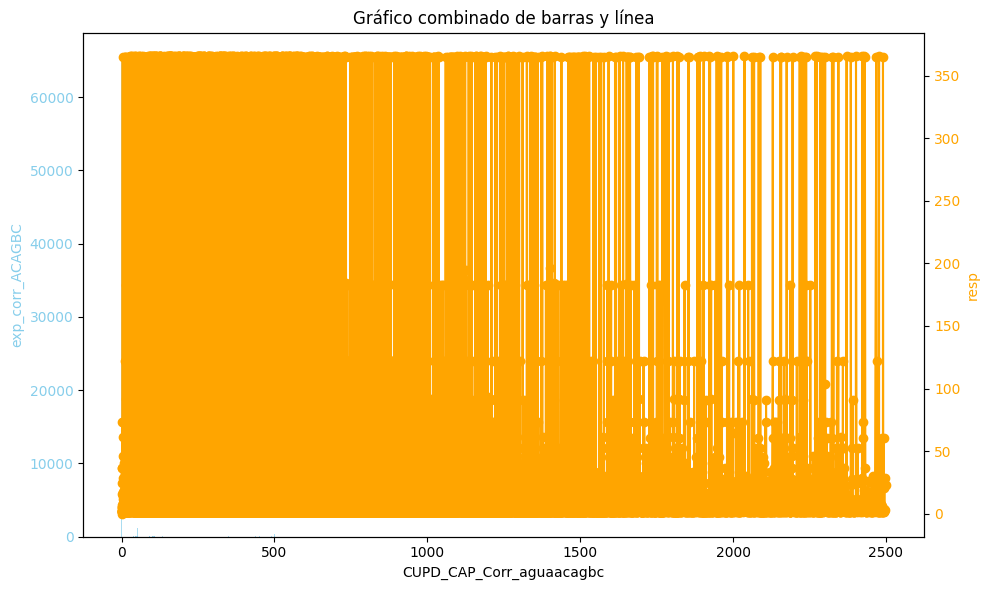

In [12]:
### Ejemplo variable importante
### Actualización de costos relacionados con agua
var='CUPD_CAP_Corr_aguaacagbc'
df_muestra[var].dtype
df_resumido = df_muestra.groupby(var).agg({peso: 'sum', 'resp': 'mean'}).reset_index()
graficar_barras_linea(df_resumido,var,peso,'resp')

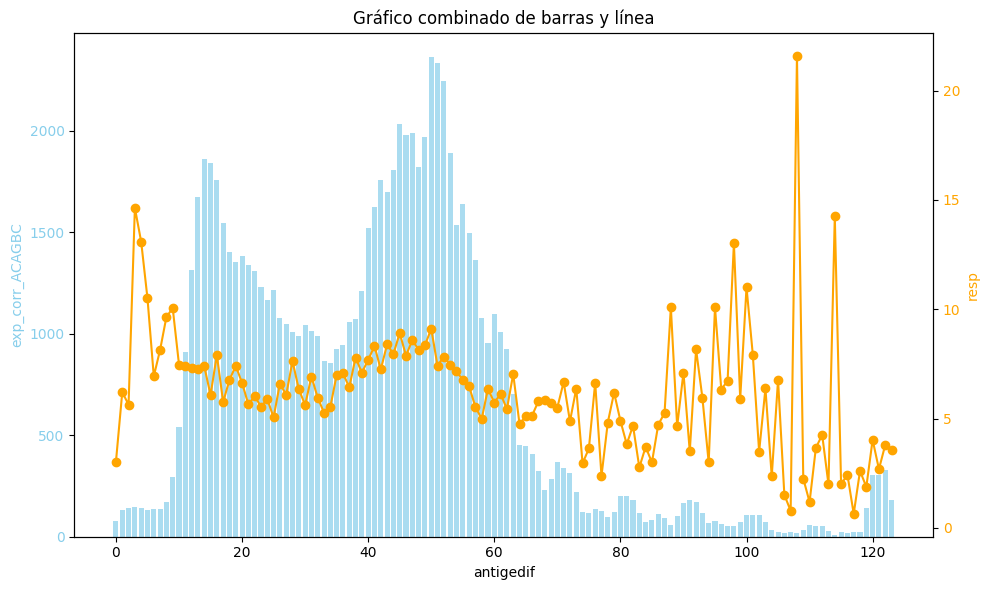

In [13]:
### Antigüedad del edificio
var='antigedif'
df_muestra[var].dtype
df_resumido = df_muestra.groupby(var).agg({peso: 'sum', 'resp': 'mean'}).reset_index()
graficar_barras_linea(df_resumido,var,peso,'resp')

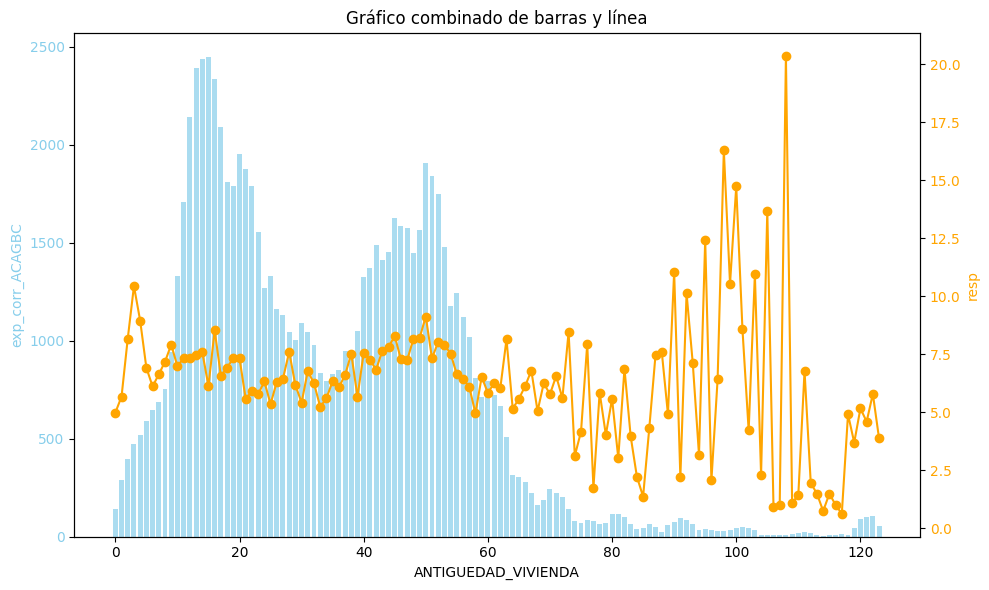

In [14]:
### Ejemplo variable importante
### Antigüedad de la vivienda
var='ANTIGUEDAD_VIVIENDA'
df_muestra[var].dtype
df_resumido = df_muestra.groupby(var).agg({peso: 'sum', 'resp': 'mean'}).reset_index()
graficar_barras_linea(df_resumido,var,peso,'resp')

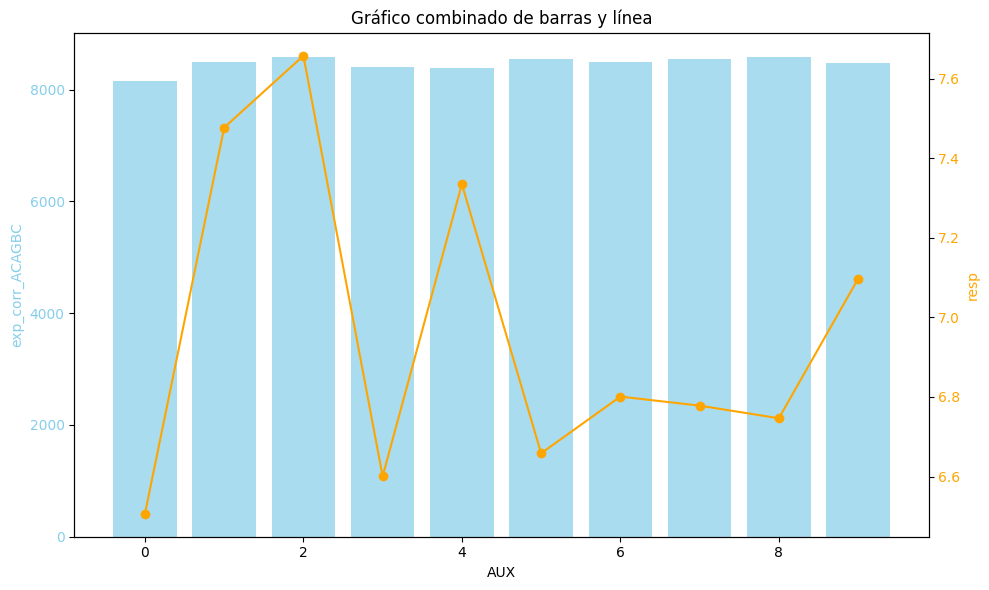

In [15]:
### Indicador auxiliar
var='AUX'
df_muestra[var].dtype
df_resumido = df_muestra.groupby(var).agg({peso: 'sum', 'resp': 'mean'}).reset_index()
graficar_barras_linea(df_resumido,var,peso,'resp')

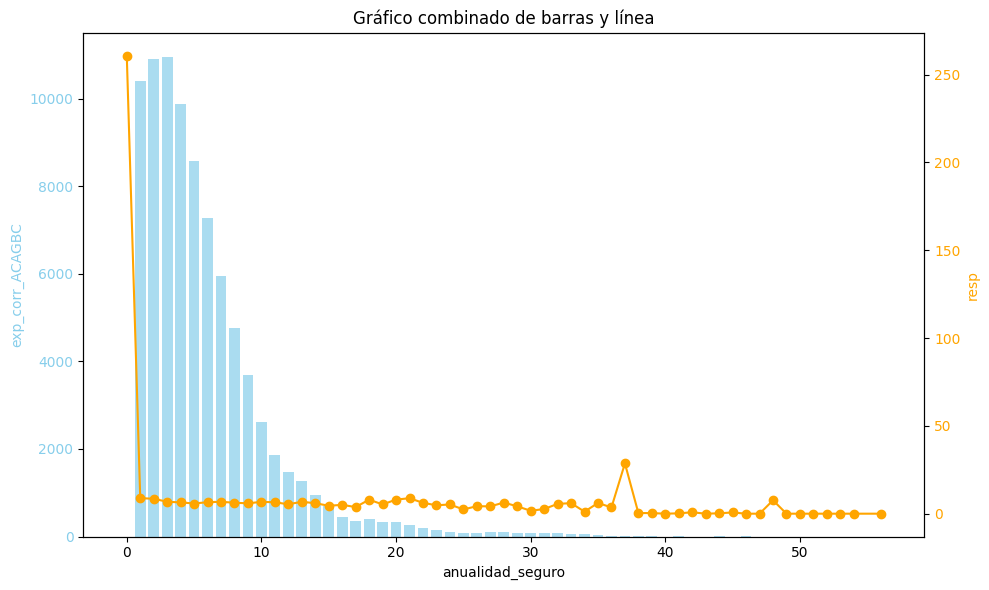

In [16]:
### frecuencia y antigüedad de las pólizas de seguro
var='anualidad_seguro'
df_muestra[var].dtype
df_resumido = df_muestra.groupby(var).agg({peso: 'sum', 'resp': 'mean'}).reset_index()
graficar_barras_linea(df_resumido,var,peso,'resp')

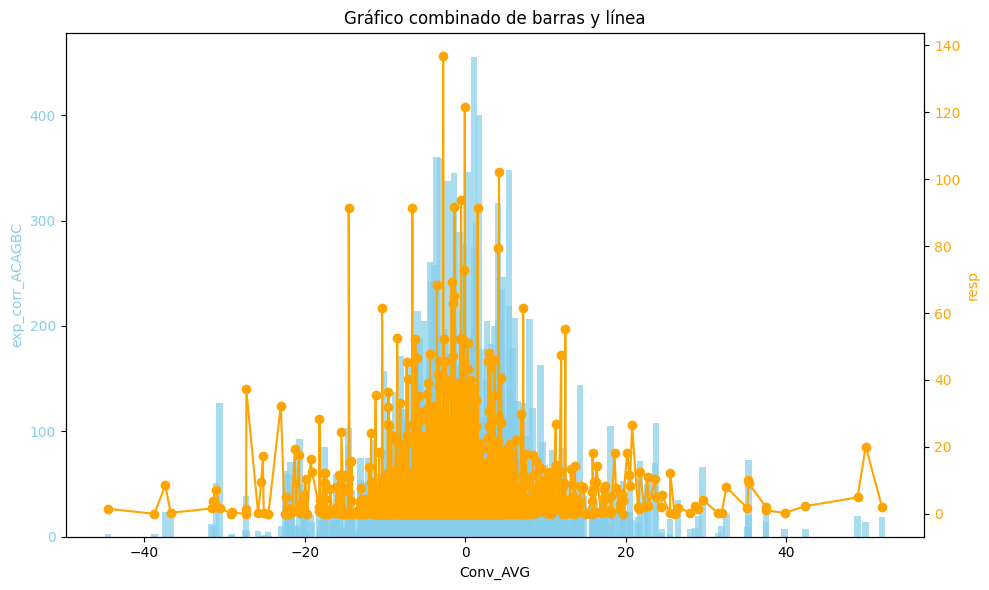

In [17]:
### Promedio de convergencia
var='Conv_AVG'
df_muestra[var].dtype
df_resumido = df_muestra.groupby(var).agg({peso: 'sum', 'resp': 'mean'}).reset_index()
graficar_barras_linea(df_resumido,var,peso,'resp')

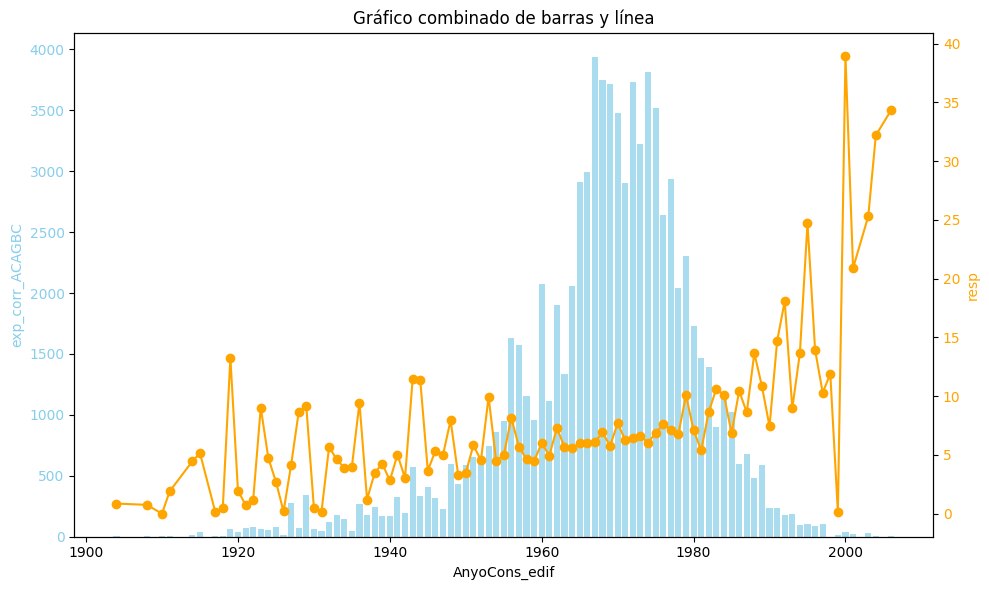

In [18]:
### Año de construcción del edificio
var='AnyoCons_edif'
df_muestra[var].dtype
df_resumido = df_muestra.groupby(var).agg({peso: 'sum', 'resp': 'mean'}).reset_index()
graficar_barras_linea(df_resumido,var,peso,'resp')

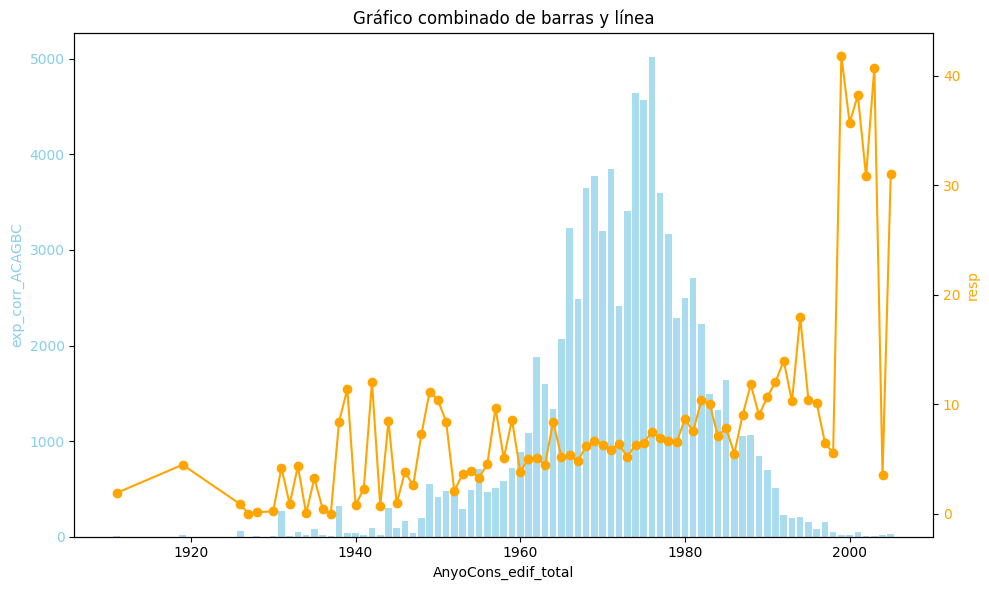

In [19]:
### Año medio de construcción total
var='AnyoCons_edif_total'
df_muestra[var].dtype
df_resumido = df_muestra.groupby(var).agg({peso: 'sum', 'resp': 'mean'}).reset_index()
graficar_barras_linea(df_resumido,var,peso,'resp')

In [13]:
antig_corregida=generar_formato_exposicion_homogenea(df_muestra, 'antigedif', peso, 10)
df_muestra['antigedif_2']=antig_corregida #Sobreescribimos la columna corregida

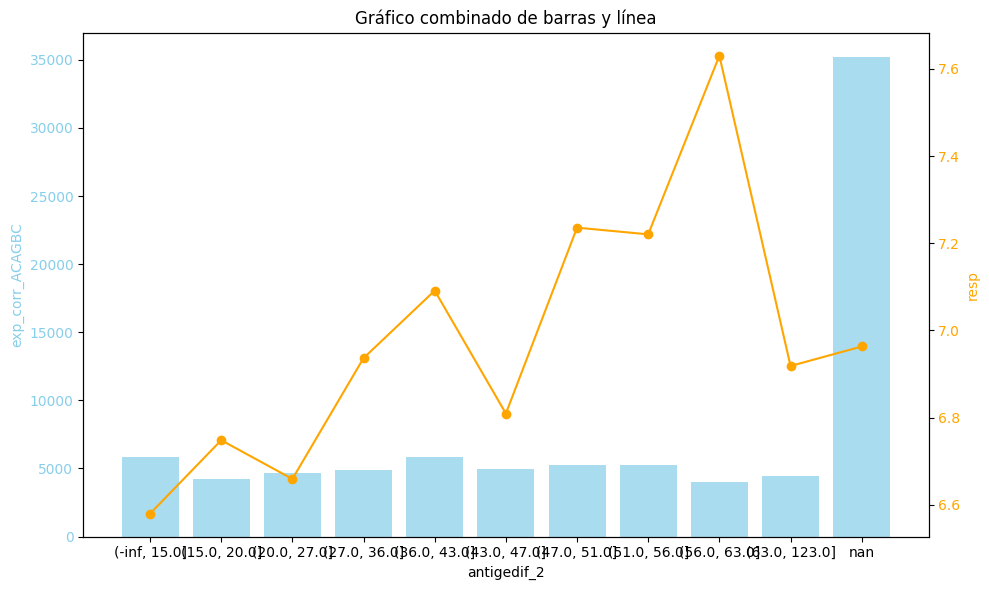

In [14]:
df_muestra['antigedif_2']=df_muestra['antigedif_2'].astype(str)
df_resumido = df_muestra.groupby('antigedif_2').agg({peso: 'sum', 'resp': 'mean'}).reset_index()
graficar_barras_linea(df_resumido,'antigedif_2',peso,'resp')

In [15]:
### Y que hacemos con los Nan? -> por ejemplo convertirlos en la moda de la variable
df_muestra['antigedif_2'].replace('nan',np.nan).mode(dropna=True)[0]

'(36.0, 43.0]'

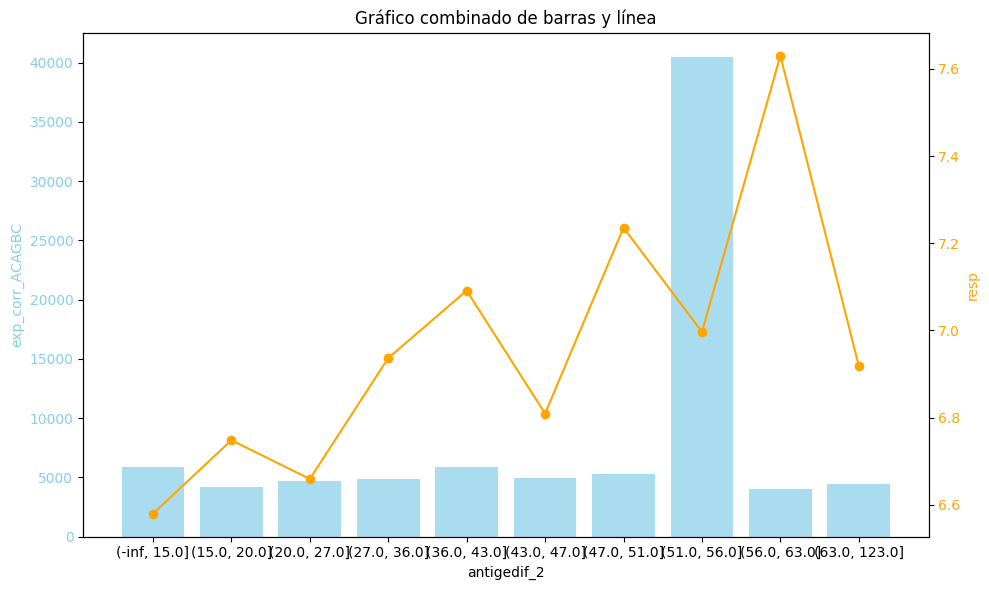

In [16]:
### Ahora sustituimos los nan por el valor moda
df_muestra['antigedif_2']=df_muestra['antigedif_2'].replace('nan','(51.0, 56.0]')
df_resumido = df_muestra.groupby('antigedif_2').agg({peso: 'sum', 'resp': 'mean'}).reset_index()
graficar_barras_linea(df_resumido,'antigedif_2',peso,'resp')

In [17]:
factores=['year','antigedif_2','anualidad_seguro','FP','K_ACAGBC','SUPERFICIE','stro_1a_AGUAACAGBC','NIF_TIPO']
df_muestra[factores].dtypes

,0
year,object
antigedif_2,object
anualidad_seguro,float64
FP,float64
K_ACAGBC,float64
SUPERFICIE,float64
stro_1a_AGUAACAGBC,float64
NIF_TIPO,object


In [18]:
# Creamos variables dummy para las columnas categóricas
key_words=['year', 'antigedif_2','NIF_TIPO']
df_encoded = pd.get_dummies(df_muestra, columns=key_words, drop_first=True)

In [19]:
cols_encoded = [each for each in df_encoded.columns if any(keyword in each for keyword in key_words)]
cols_encoded

['year_2021.0',
 'year_2022.0',
 'year_2023.0',
 'antigedif_2_(15.0, 20.0]',
 'antigedif_2_(20.0, 27.0]',
 'antigedif_2_(27.0, 36.0]',
 'antigedif_2_(36.0, 43.0]',
 'antigedif_2_(43.0, 47.0]',
 'antigedif_2_(47.0, 51.0]',
 'antigedif_2_(51.0, 56.0]',
 'antigedif_2_(56.0, 63.0]',
 'antigedif_2_(63.0, 123.0]',
 'NIF_TIPO_J',
 'NIF_TIPO_N']

In [20]:
factores_updated=[each for each in factores if each not in key_words]
factores_updated

['anualidad_seguro', 'FP', 'K_ACAGBC', 'SUPERFICIE', 'stro_1a_AGUAACAGBC']

In [21]:
list(set(cols_encoded+factores_updated))

['year_2021.0',
 'FP',
 'stro_1a_AGUAACAGBC',
 'antigedif_2_(15.0, 20.0]',
 'K_ACAGBC',
 'year_2023.0',
 'SUPERFICIE',
 'antigedif_2_(36.0, 43.0]',
 'antigedif_2_(51.0, 56.0]',
 'antigedif_2_(43.0, 47.0]',
 'NIF_TIPO_N',
 'anualidad_seguro',
 'antigedif_2_(63.0, 123.0]',
 'NIF_TIPO_J',
 'antigedif_2_(20.0, 27.0]',
 'antigedif_2_(27.0, 36.0]',
 'antigedif_2_(47.0, 51.0]',
 'antigedif_2_(56.0, 63.0]',
 'year_2022.0']

In [22]:
# Prepara los datos
df_encoded = df_encoded[list(set(cols_encoded+factores_updated))].astype('float')
X=df_encoded# Selecciona las variables predictoras
X = sm.add_constant(X)            # Agrega una constante al modelo (intercepto)
y = df_muestra['resp']                   # Variable de respuesta

# Definir la exposición como un offset en logaritmo
offset = np.log(df_muestra[peso])

# Crear el modelo GLM con enlace logarítmico y familia Poisson
modelo = sm.GLM(y, X, family=sm.families.Poisson(), offset=offset)

# Ajustar el modelo
resultado = modelo.fit()

# Mostrar los resultados del modelo
print(resultado.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   resp   No. Observations:               216982
Model:                            GLM   Df Residuals:                   216962
Model Family:                 Poisson   Df Model:                           19
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -9.3570e+06
Date:                Fri, 29 Nov 2024   Deviance:                   1.8491e+07
Time:                        02:14:18   Pearson chi2:                 5.27e+09
No. Iterations:                    20   Pseudo R-squ. (CS):             0.9979
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [23]:
def calculate_bic(model):
    n = len(model.model.endog)  # Número de observaciones
    k = model.df_model + 1  # Número de parámetros (df_model incluye los coeficientes, sumamos 1 por el intercepto)
    bic = np.log(n) * k - 2 * model.llf  # BIC = ln(n) * k - 2 * log-verosimilitud
    return bic
calculate_bic(resultado)

18714299.898817666

In [24]:
factores=['year','antigedif_2','anualidad_seguro','FP','K_ACAGBC','SUPERFICIE','stro_1a_AGUAACAGBC']
df_muestra[factores].dtypes

,0
year,object
antigedif_2,object
anualidad_seguro,float64
FP,float64
K_ACAGBC,float64
SUPERFICIE,float64
stro_1a_AGUAACAGBC,float64


In [25]:
# Creamos variables dummy para las columnas categóricas
key_words=['year', 'antigedif_2']
df_encoded = pd.get_dummies(df_muestra, columns=key_words, drop_first=True)

In [26]:
cols_encoded = [each for each in df_encoded.columns if any(keyword in each for keyword in key_words)]
cols_encoded

['year_2021.0',
 'year_2022.0',
 'year_2023.0',
 'antigedif_2_(15.0, 20.0]',
 'antigedif_2_(20.0, 27.0]',
 'antigedif_2_(27.0, 36.0]',
 'antigedif_2_(36.0, 43.0]',
 'antigedif_2_(43.0, 47.0]',
 'antigedif_2_(47.0, 51.0]',
 'antigedif_2_(51.0, 56.0]',
 'antigedif_2_(56.0, 63.0]',
 'antigedif_2_(63.0, 123.0]']

In [27]:
factores_updated=[each for each in factores if each not in key_words]
factores_updated

['anualidad_seguro', 'FP', 'K_ACAGBC', 'SUPERFICIE', 'stro_1a_AGUAACAGBC']

In [28]:
# Prepara los datos
df_encoded = df_encoded[list(set(cols_encoded+factores_updated))].astype('float')
X=df_encoded# Selecciona las variables predictoras
X = sm.add_constant(X)            # Agrega una constante al modelo (intercepto)
y = df_muestra['resp']                   # Variable de respuesta

# Definir la exposición como un offset en logaritmo
offset = np.log(df_muestra[peso])

# Crear el modelo GLM con enlace logarítmico y familia Poisson
modelo1 = sm.GLM(y, X, family=sm.families.Poisson(), offset=offset)

# Ajustar el modelo
resultado1 = modelo1.fit()

# Mostrar los resultados del modelo
print(resultado.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   resp   No. Observations:               216982
Model:                            GLM   Df Residuals:                   216962
Model Family:                 Poisson   Df Model:                           19
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -9.3570e+06
Date:                Fri, 29 Nov 2024   Deviance:                   1.8491e+07
Time:                        02:14:42   Pearson chi2:                 5.27e+09
No. Iterations:                    20   Pseudo R-squ. (CS):             0.9979
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [29]:
calculate_bic(resultado1)

18770515.921012823

In [20]:
# Importar las bibliotecas
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

# Función para calcular BIC
def calculate_bic(model):
    n = len(model.model.endog)  # Número de observaciones
    k = model.df_model + 1  # Número de parámetros
    bic = np.log(n) * k - 2 * model.llf
    return bic

# Cargar los datos
file_path_parquet = '/content/drive/MyDrive/AGUA_V2_40.parquet'
df_muestra = pd.read_parquet(file_path_parquet)

# Definir variables clave
selected_vars = [
    "CUPD_CAP_Corr_aguaacagbc", "antigedif", "ANTIGUEDAD_VIVIENDA", "AUX",
    "anualidad_seguro", "Conv_AVG", "AnyoCons_edif", "AnyoCons_edif_total"
]
peso = 'exp_corr_ACAGBC'
var_resp = 'stro_Corr_AGUAACAGBC'

# Crear la variable de respuesta
df_muestra = df_muestra[df_muestra[peso] > 0]  # Filtrar filas con peso positivo
df_muestra['resp'] = df_muestra[var_resp] / df_muestra[peso]  # Crear variable de respuesta

# Verificar si las variables seleccionadas están presentes
missing_vars = [var for var in selected_vars if var not in df_muestra.columns]
if missing_vars:
    raise ValueError(f"Las siguientes variables no están en el DataFrame: {missing_vars}")

# Preparar los datos para el modelo
df_selected = df_muestra[selected_vars + ['resp', peso]].copy()  # Incluir peso y respuesta
df_selected.fillna(df_selected.median(numeric_only=True), inplace=True)  # Reemplazar valores nulos

# Estandarizar las variables seleccionadas
scaler = StandardScaler()
df_selected[selected_vars] = scaler.fit_transform(df_selected[selected_vars])

# Preparar X e y para el modelo
X_new = sm.add_constant(df_selected[selected_vars])  # Agregar constante al modelo
y_new = df_selected['resp']  # Variable de respuesta

# Definir la exposición como un offset en logaritmo
offset_new = np.log(df_selected[peso])

# Crear el modelo GLM con las nuevas variables
modelo_new = sm.GLM(y_new, X_new, family=sm.families.Poisson(), offset=offset_new)

# Ajustar el modelo
resultado_new = modelo_new.fit()

# Mostrar los resultados del modelo
print(resultado_new.summary())

# Calcular el BIC
bic_new = calculate_bic(resultado_new)
print(f"\nBIC del modelo ajustado: {bic_new}")


                 Generalized Linear Model Regression Results                  
Dep. Variable:                   resp   No. Observations:               216982
Model:                            GLM   Df Residuals:                   216973
Model Family:                 Poisson   Df Model:                            8
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -9.6112e+06
Date:                Sat, 07 Dec 2024   Deviance:                   1.9000e+07
Time:                        02:18:53   Pearson chi2:                 5.43e+09
No. Iterations:                    12   Pseudo R-squ. (CS):             0.9786
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

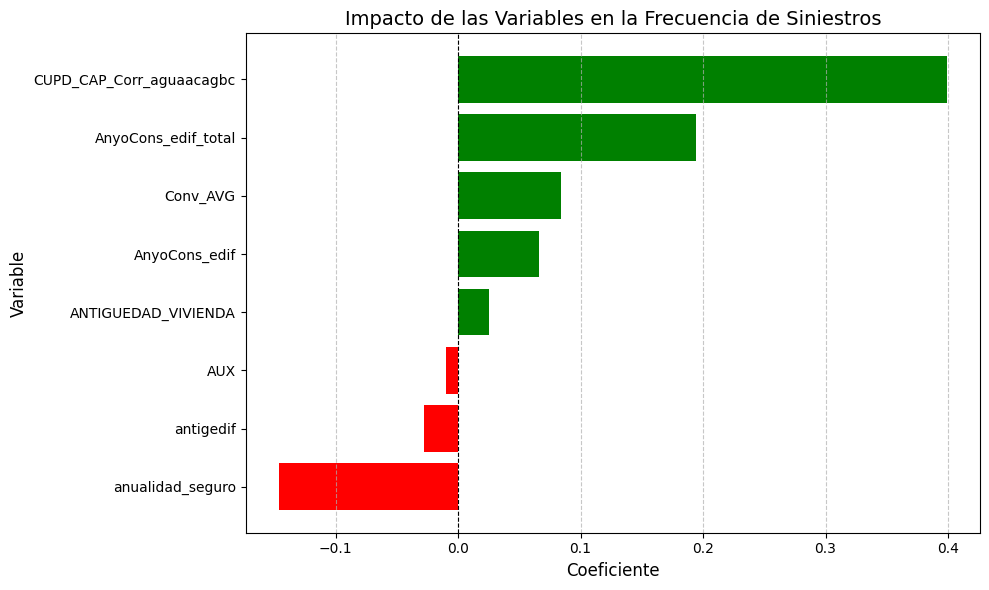

In [21]:
# Importar las bibliotecas
import pandas as pd
import matplotlib.pyplot as plt

# Coeficientes y nombres de las variables (del modelo ajustado)
coeficientes = {
    "CUPD_CAP_Corr_aguaacagbc": 0.3989,
    "antigedif": -0.0283,
    "ANTIGUEDAD_VIVIENDA": 0.0250,
    "AUX": -0.0096,
    "anualidad_seguro": -0.1464,
    "Conv_AVG": 0.0836,
    "AnyoCons_edif": 0.0657,
    "AnyoCons_edif_total": 0.1946
}

# Crear un DataFrame para el gráfico
df_coef = pd.DataFrame(list(coeficientes.items()), columns=["Variable", "Coeficiente"])

# Ordenar las variables por el valor del coeficiente
df_coef = df_coef.sort_values(by="Coeficiente", ascending=True)

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(df_coef["Variable"], df_coef["Coeficiente"], color=["red" if coef < 0 else "green" for coef in df_coef["Coeficiente"]])
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')  # Línea vertical en 0
plt.title("Impacto de las Variables en la Frecuencia de Siniestros", fontsize=14)
plt.xlabel("Coeficiente", fontsize=12)
plt.ylabel("Variable", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# Mostrar el gráfico
plt.show()


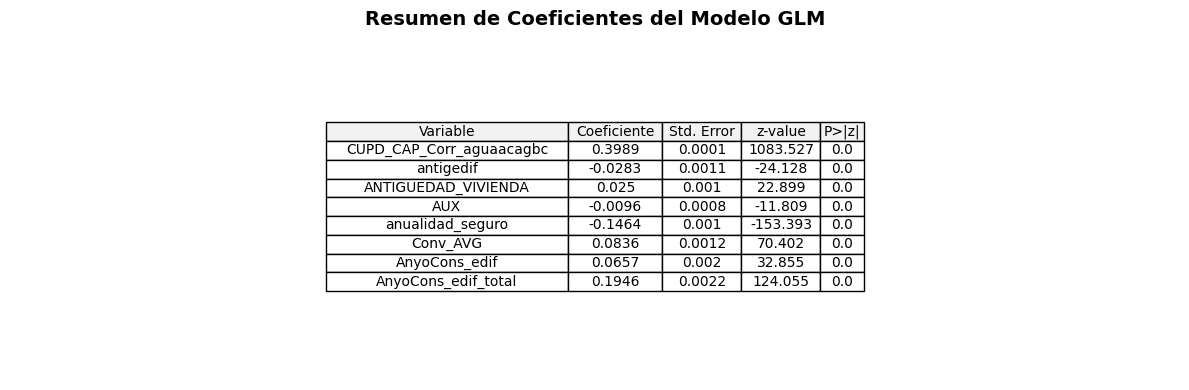

In [22]:
# Importar las bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.table import Table

# Datos del modelo (coeficientes, errores estándar, z-score, y significancia)
resultados_glm = {
    "Variable": [
        "CUPD_CAP_Corr_aguaacagbc", "antigedif", "ANTIGUEDAD_VIVIENDA", "AUX",
        "anualidad_seguro", "Conv_AVG", "AnyoCons_edif", "AnyoCons_edif_total"
    ],
    "Coeficiente": [0.3989, -0.0283, 0.0250, -0.0096, -0.1464, 0.0836, 0.0657, 0.1946],
    "Std. Error": [0.0001, 0.0011, 0.0010, 0.0008, 0.0010, 0.0012, 0.0020, 0.0022],
    "z-value": [1083.527, -24.128, 22.899, -11.809, -153.393, 70.402, 32.855, 124.055],
    "P>|z|": [0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000]
}

# Convertir los datos a un DataFrame
df_resultados = pd.DataFrame(resultados_glm)

# Crear una tabla con matplotlib
fig, ax = plt.subplots(figsize=(12, 4))
ax.axis('off')  # Ocultar los ejes

# Agregar la tabla
tabla = ax.table(
    cellText=df_resultados.values,
    colLabels=df_resultados.columns,
    loc='center',
    cellLoc='center',
    colColours=["#f2f2f2"] * df_resultados.shape[1]  # Colores de encabezado
)

# Ajustar diseño
tabla.auto_set_font_size(False)
tabla.set_fontsize(10)
tabla.auto_set_column_width(col=list(range(len(df_resultados.columns))))

# Agregar título
plt.title("Resumen de Coeficientes del Modelo GLM", fontsize=14, fontweight="bold")

# Mostrar la tabla
plt.tight_layout()
plt.show()


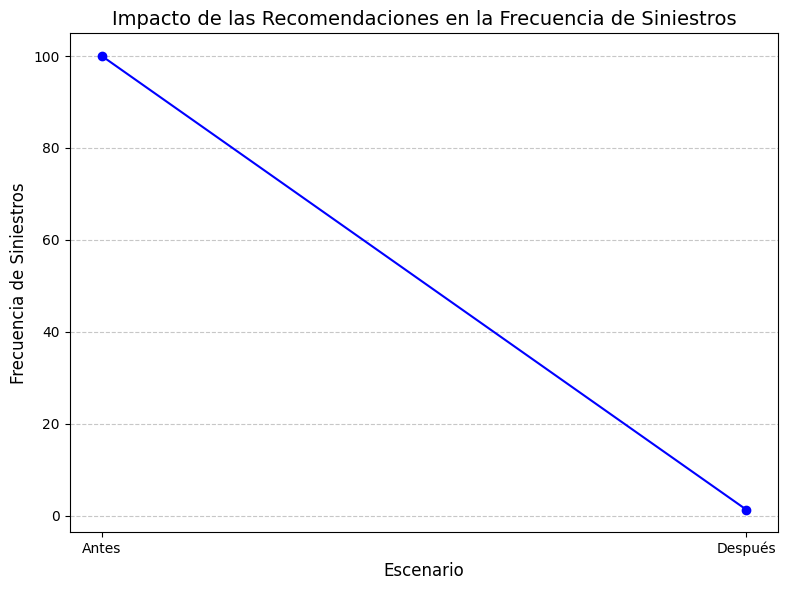

In [23]:
# Importar las bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Crear datos simulados basados en los coeficientes del modelo
variables = ["CUPD_CAP_Corr_aguaacagbc", "antigedif", "ANTIGUEDAD_VIVIENDA", "AUX",
             "anualidad_seguro", "Conv_AVG", "AnyoCons_edif", "AnyoCons_edif_total"]

# Frecuencia inicial de siniestros (simulada)
frecuencia_inicial = 100  # Valor base inicial de frecuencia

# Simular la mejora esperada
mejoras = {
    "CUPD_CAP_Corr_aguaacagbc": -10,  # Reducción en costos de actualización
    "antigedif": +5,  # Aumento en la antigüedad promedio
    "ANTIGUEDAD_VIVIENDA": +3,  # Incremento en la antigüedad específica
    "AUX": 0,  # Sin cambio en esta variable auxiliar
    "anualidad_seguro": +2,  # Incentivar renovaciones más frecuentes
    "Conv_AVG": -5,  # Reducción en convergencia negativa
    "AnyoCons_edif": +1,  # Mejoras en calidad de construcción
    "AnyoCons_edif_total": +2  # Mejoras en construcción promedio
}

# Coeficientes del modelo (del GLM ajustado)
coeficientes = {
    "CUPD_CAP_Corr_aguaacagbc": 0.3989,
    "antigedif": -0.0283,
    "ANTIGUEDAD_VIVIENDA": 0.0250,
    "AUX": -0.0096,
    "anualidad_seguro": -0.1464,
    "Conv_AVG": 0.0836,
    "AnyoCons_edif": 0.0657,
    "AnyoCons_edif_total": 0.1946
}

# Calcular la mejora total esperada en la frecuencia
impactos = {var: coeficientes[var] * mejoras[var] for var in variables}
mejora_total = sum(impactos.values())

# Generar las frecuencias simuladas antes y después
frecuencias = {
    "Antes": frecuencia_inicial,
    "Después": frecuencia_inicial * np.exp(mejora_total)  # Aplicar la mejora en log
}

# Crear una gráfica de tendencias
plt.figure(figsize=(8, 6))
plt.plot(list(frecuencias.keys()), list(frecuencias.values()), marker='o', linestyle='-', color='blue')
plt.title("Impacto de las Recomendaciones en la Frecuencia de Siniestros", fontsize=14)
plt.ylabel("Frecuencia de Siniestros", fontsize=12)
plt.xlabel("Escenario", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

# Mostrar la gráfica
plt.show()
